# Deep Learning based COVID-19 X-ray Image Classification

## Understanding the objective
- To predict the result of lung X-ray image (postive/negative) based on Covid-19.

## Introduction


*   In the realm of data-driven solutions, a robust pipeline is essential to harness the full potential of information. This project encapsulates a comprehensive approach, seamlessly integrating various stages from data collection to model evaluation.
*   The journey commences with meticulous data acquisition, followed by a detailed exploration of the dataset through advanced visualization techniques.
*   The pivotal core lies in the training of a Convolutional Neural Network (CNN), a deep learning model renowned for its proficiency in image-related tasks.
*   Further refinement is achieved through parameter tuning, fine-tuning the model to extract optimal performance. Finally, an in-depth evaluation culminates the process, providing critical insights into the model's efficacy.
*   This end-to-end pipeline exemplifies a holistic methodology, demonstrating how each step synergistically contributes to the overarching goal of generating accurate and reliable results.





In [ ]:
# Import neccessary libraies and packages
import warnings
import os
from glob import glob
from PIL import Image
import numpy as np
import pandas as pd
import cv2
import random
import albumentations as A
import plotly.express as px
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import seaborn as sns
from keras import layers, models
import tensorflow as tf
import tensorflow as keras
from keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Dense, Flatten, Dropout, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, recall_score, accuracy_score, precision_score, f1_score

In [ ]:
# Mounting the Google Drive to the Colab environment
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Reading The Data

Creating a list of labels for different types of X-rays images in the dataset.

In [ ]:
files = ['Normal', 'COVID','Viral Pneumonia']
path = '/content/drive/MyDrive/FYP/COVID-19_Radiography_Dataset'

For data processing, it iterates through files in different subdirectories specified in files and appends their paths and labels to the data list.

In [ ]:
data = []
# Loop through each label in files and append file path and label to the data list
for id, level in enumerate(files):
    for file in os.listdir(os.path.join(path, level+'/'+'images')):
        data.append([level +'/' +'images'+ '/'+file, level])


data = pd.DataFrame(data, columns = ['image_file', 'corona_result'])

data['path'] = path + '/' + data['image_file']
data['corona_result'] = data['corona_result'].map({'Normal': 'Normal', 'COVID': 'Covid_positive', 'Viral Pneumonia':'Viral_Pneumonia'})

data.head()

,image_file,corona_result,path
0,Normal/images/Normal-2182.png,Normal,/content/drive/MyDrive/FYP/COVID-19_Radiograph...
1,Normal/images/Normal-229.png,Normal,/content/drive/MyDrive/FYP/COVID-19_Radiograph...
2,Normal/images/Normal-2311.png,Normal,/content/drive/MyDrive/FYP/COVID-19_Radiograph...
3,Normal/images/Normal-2248.png,Normal,/content/drive/MyDrive/FYP/COVID-19_Radiograph...
4,Normal/images/Normal-2150.png,Normal,/content/drive/MyDrive/FYP/COVID-19_Radiograph...


Even the dataset is carefully chosen, exploratory data analysis is still needed to double check the data quality.

In [ ]:
samples,features = data.shape
duplicated = data.duplicated().sum()
null_values = data.isnull().sum().sum()

print('Basic EDA')
print('Number of samples: %d'%(samples))
print('Number of duplicated values: %d'%(duplicated))
print('Number of Null samples: %d' % (null_values))

Basic EDA
Number of samples: 5833
Number of duplicated values: 0
Number of Null samples: 0


Save the number of samples to a varaible for data visualization.

In [ ]:
no_of_samples = 5833

Create a image column to map the corresponding image data and convert to NumPy for easy manipulation and processing of the image data using numerical operations.

In [ ]:
%%time
data['image'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((75,75))))

CPU times: user 14 s, sys: 1.4 s, total: 15.4 s
Wall time: 14min 32s


Generates a bar chart to visualize the distribution of different corona results. Normal and Covid_postive compose most of the dataset while Viral_Pneumonia has the least number. It will be interesting to see if the model will have greater difficulty in identifying Pneumonia or Covid samples

In [ ]:
# Creating a new DataFrame with counts for each corona_result
df = data['corona_result'].value_counts().reset_index()
df.columns = ['corona_result', 'Count']
df = df.sort_values(by=['Count'], ascending=False)

# Define a color mapping
color_map = {
    'Normal': 'green',
    'Covid_positive': 'red',
    'Viral_Pneumonia': 'blue'
}

fig = px.bar(df, x='corona_result', y='Count',
             color='corona_result',
             color_discrete_map=color_map,
             width=600,
             color_continuous_scale='BrBg')

fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
fig.show()

# Data Visualization


Based on the EDA:
*   The dataset contains a reasonable number of images
*   No data cleansing is required
*   We can investigate image patterns and relantionships between the classes

Calculates statistical values (mean, standard deviation, max, and min) for each image in the dataset. The purpose is to generate kernel density plots to visualize the distribution of mean, max, and min values of image. These plots help in understanding the characteristics of the images in different classes.

In [ ]:
mean_val = []
std_dev_val = []
max_val = []
min_val = []

# Loop through each sample and calculate mean, standard deviation, max, and min values for each image
for i in range(0, no_of_samples):
    mean_val.append(data['image'][i].mean())
    std_dev_val.append(np.std(data['image'][i]))
    max_val.append(data['image'][i].max())
    min_val.append(data['image'][i].min())

imageEDA = data.loc[:,['image','corona_result','path']]
imageEDA['mean'] = mean_val
imageEDA['stedev'] = std_dev_val
imageEDA['max'] = max_val
imageEDA['min'] = min_val

imageEDA['subt_mean'] = imageEDA['mean'].mean() - imageEDA['mean']

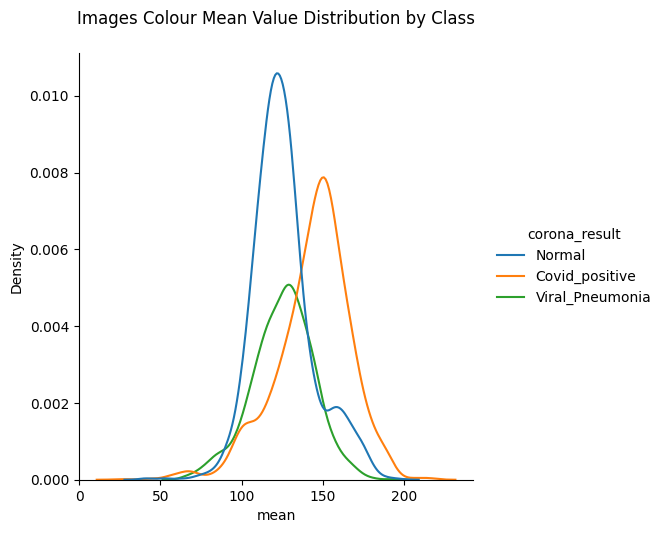

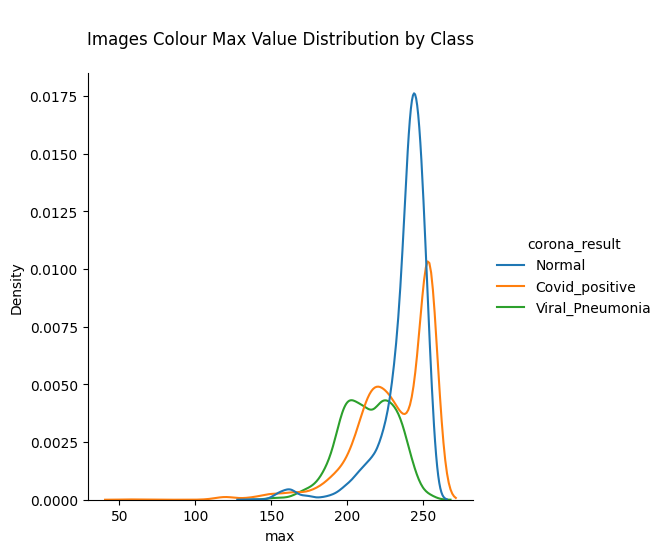

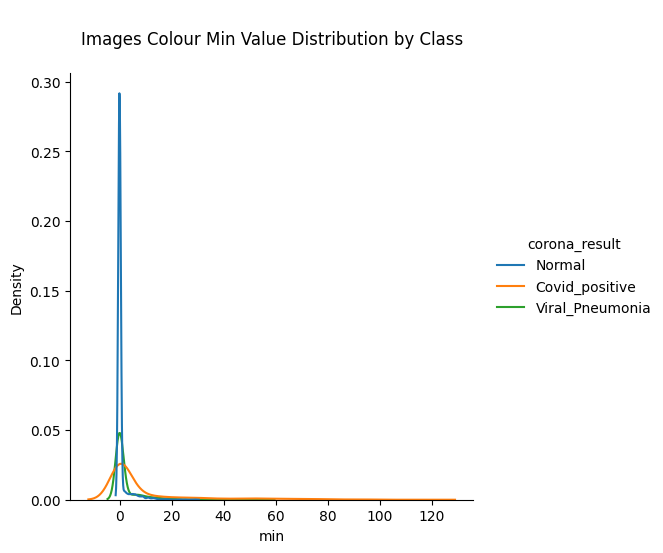

In [ ]:
# Create and display kernel density plots for mean, max, and min values by class
ax1 = sns.displot(data = imageEDA, x = 'mean', kind="kde", hue = 'corona_result');
plt.title('Images Colour Mean Value Distribution by Class\n', fontsize = 12);

ax2 = sns.displot(data = imageEDA, x = 'max', kind="kde", hue = 'corona_result');
plt.title('\nImages Colour Max Value Distribution by Class\n', fontsize = 12);

ax3 = sns.displot(data = imageEDA, x = 'min', kind="kde", hue = 'corona_result');
plt.title('\nImages Colour Min Value Distribution by Class\n', fontsize = 12);


*   All the classes fall on the range of 100-150 for the mean value distribution.
*   Normal and Covid_postive have the max value close to 255 while Viral_Pneumnonia has lower range 200-225.
*   All the classes have 0 for min value as expected because they are x-rays images and the darkest color in the image is pure black.

Create a scatter plot to visualize the relationship between the mean and standard deviation of color channels in the image samples.

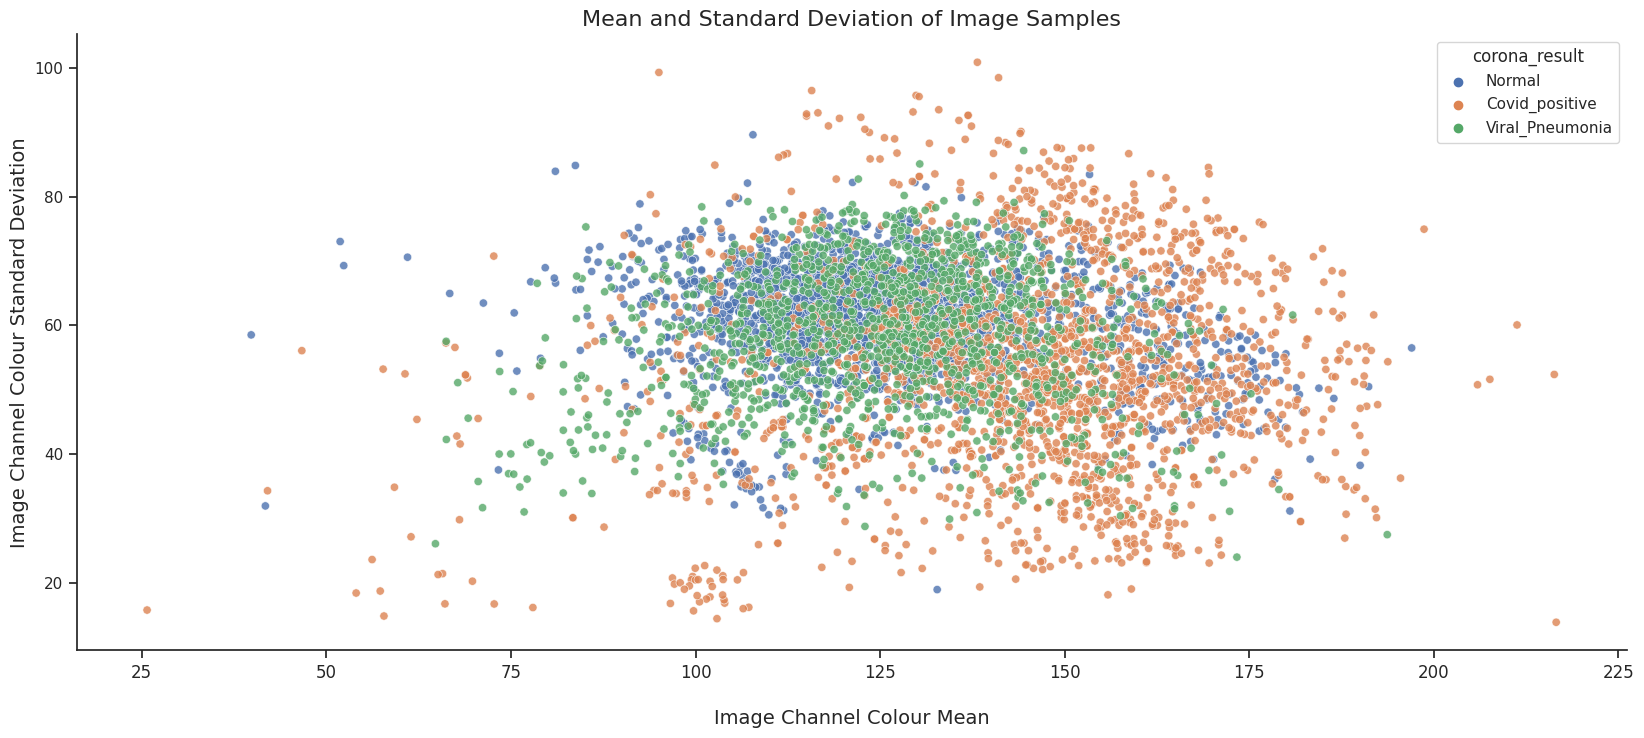

In [ ]:
plt.figure(figsize = (20, 8))
sns.set(style = "ticks", font_scale = 1)
ax = sns.scatterplot(data = imageEDA, x = "mean", y = imageEDA['stedev'], hue = 'corona_result', alpha = 0.8);
sns.despine(top = True, right = True, left = False, bottom = False)
plt.xticks(rotation = 0, fontsize = 12)
ax.set_xlabel('\nImage Channel Colour Mean', fontsize = 14)
ax.set_ylabel('Image Channel Colour Standard Deviation', fontsize = 14)
plt.title('Mean and Standard Deviation of Image Samples', fontsize = 16);



*   Most images are gathered in the central region of the scatter plot as here is not much contrast between their pixel values
*   Viral_Pneumnonia seems to be quite concenrtated on the middle of the plot where Covid_postive is more spread apart to the right of the plot.
*   All the classes are overlapping color mean range: 100 - 175


Create a scatter plot to visualize the relationship between the mean and standard deviation of the class individually.

<Figure size 1000x800 with 0 Axes>

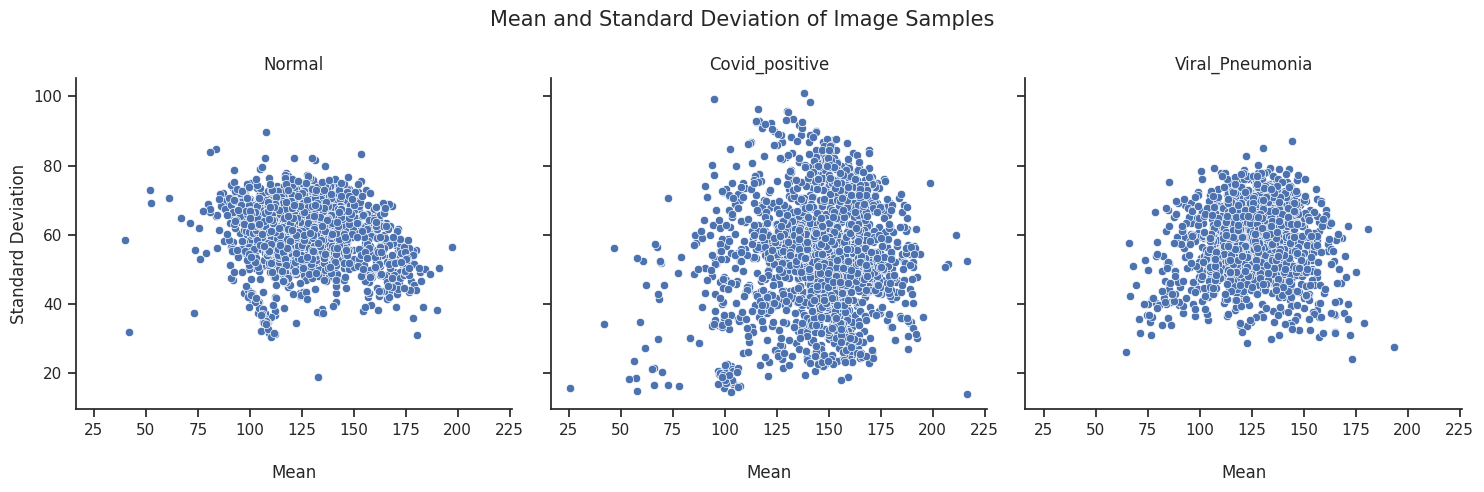

In [ ]:
plt.figure(figsize = (10, 8));
g = sns.FacetGrid(imageEDA, col = "corona_result", height = 5);
g.map_dataframe(sns.scatterplot, x = 'mean', y = 'stedev');
g.set_titles(col_template = "{col_name}", row_template= "{row_name}", size = 12);
g.fig.subplots_adjust(top = .7);
g.fig.suptitle('Mean and Standard Deviation of Image Samples', fontsize = 15);
axes = g.axes.flatten();
axes[0].set_ylabel('Standard Deviation');
for ax in axes:
    ax.set_xlabel('\nMean');
g.fig.tight_layout()



*  The Normal samples and Viral_Pneumnonia samples have a similar scatter.In other words, the spread of data points around the mean may be comparable for these two categories.
*   Covid_postive samples are more spread apart. It may have a greater diversity in their color statistics compared to the other two categories.


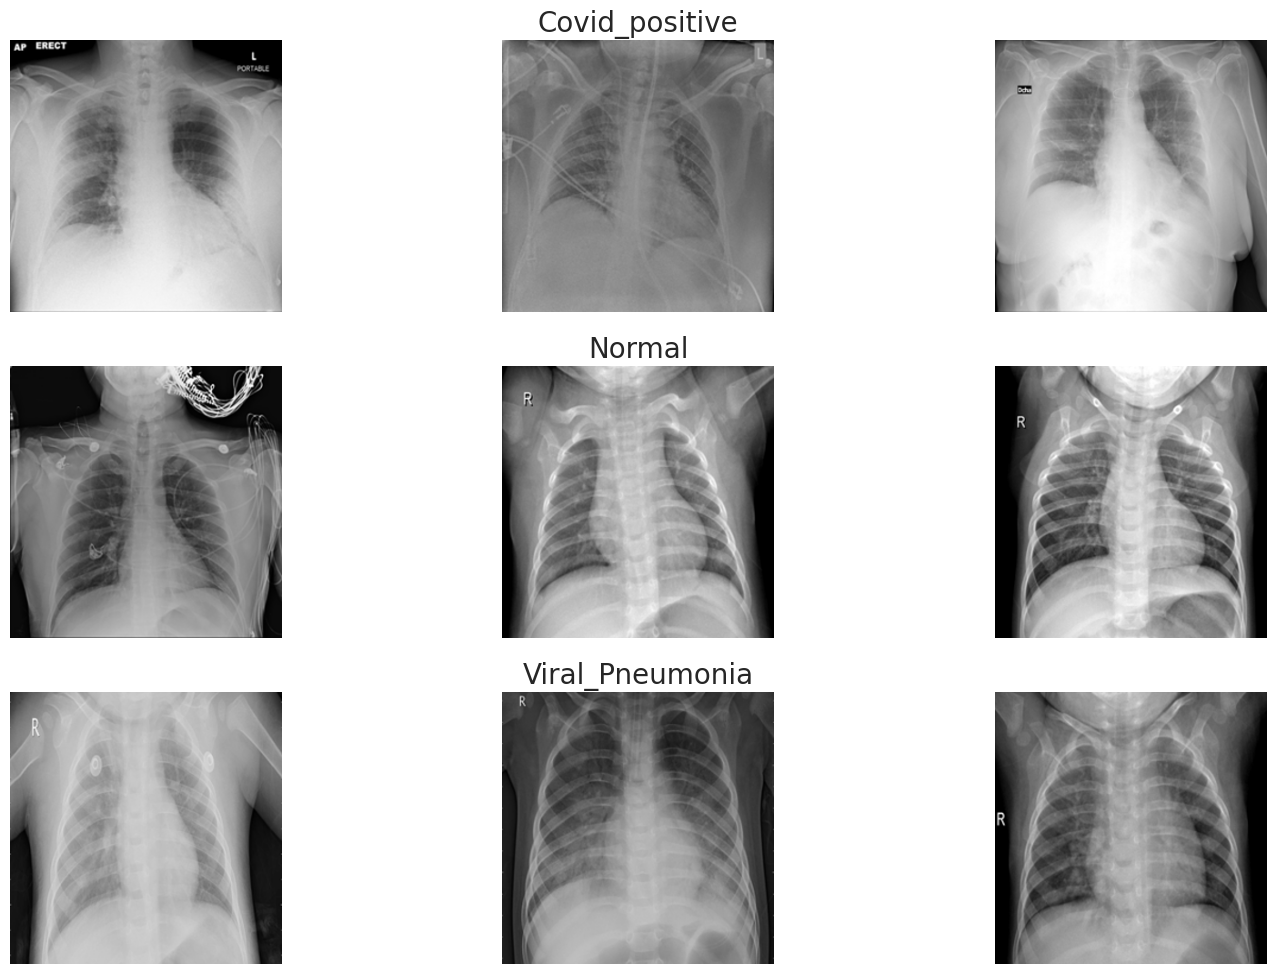

In [ ]:
n_samples = 3

fig, m_axs = plt.subplots(3, n_samples, figsize = (6*n_samples, 3*4))

# Loop through each class and display a random sample of images
for n_axs, (type_name, type_rows) in zip(m_axs, data.sort_values(['corona_result']).groupby('corona_result')):
    n_axs[1].set_title(type_name, fontsize = 20)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state = 1234).iterrows()):
        picture = c_row['path']
        image = cv2.imread(picture)
        c_ax.imshow(image)
        c_ax.axis('off')

Grayscale images only have one channel representing the intensity of light, which ranges from black to white. In grayscale, each pixel is represented by a single 8-bit number, where 0 represents black and 255 represents white.

## Albumentations

Visually preview how an image appears after undergoing various geometric transformations. This feature offers valuable insights into how each transformation alters the image's appearance.


In [ ]:
# Plot multiple images with titles
def plot_multiple_img(img_matrix_list, title_list, ncols, main_title = ""):

    fig, axis = plt.subplots(figsize = (15, 8), nrows = 2, ncols = ncols, squeeze = False)
    fig.suptitle(main_title, fontsize = 18)
    fig.subplots_adjust(wspace = 0.3)
    fig.subplots_adjust(hspace = 0.3)

    for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
        axis[i // ncols][i % ncols].imshow(img)
        axis[i // ncols][i % ncols].set_title(title, fontsize = 15)

    plt.show()

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1258: FutureWarning:

This class has been deprecated. Please use RandomBrightnessContrast

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1284: FutureWarning:

RandomContrast has been deprecated. Please use RandomBrightnessContrast



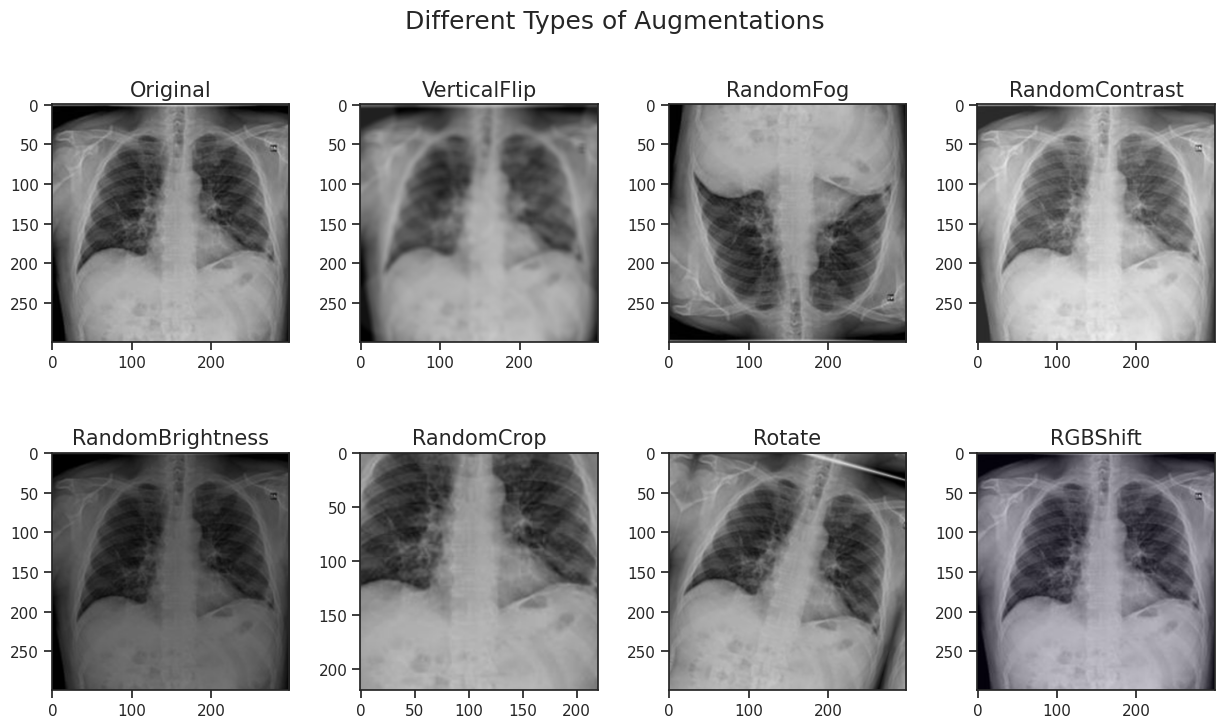

In [ ]:
chosen_image = cv2.imread("/content/drive/MyDrive/COVID-19_Radiography_Dataset/COVID/images/COVID-101.png")

albumentation_list = [A.RandomFog(p = 1),A.VerticalFlip(p = 1), A.RandomBrightness(p = 1),A.RandomContrast(limit = 0.6, p = 1),
                      A.RandomCrop(p = 1,height = 220, width = 220),
                      A.Rotate(p = 1, limit = 90), A.RGBShift(p = 1)]

# Apply each augmentation and store the resulting images
img_matrix_list = []
bboxes_list = []
for aug_type in albumentation_list:
    img = aug_type(image = chosen_image)['image']
    img_matrix_list.append(img)

img_matrix_list.insert(0,chosen_image)

titles_list = ["Original", "VerticalFlip", "RandomFog", "RandomContrast", "RandomBrightness", "RandomCrop", "Rotate", "RGBShift"]

plot_multiple_img(img_matrix_list, titles_list, ncols = 4, main_title = "Different Types of Augmentations")

# Model Training

Prepare the dataset for machine learning model. It reads, resizes, and normalizes the images while assigning categorical labels based on the 'corona_result' column.

In [ ]:
all_data = []

# Storing images and their labels into a list for further Train Test split
{'Normal': 'Normal', 'COVID': 'Covid_positive', 'Viral Pneumonia':'Viral_Pneumonia'}
for i in range(len(data)):
    image = cv2.imread(data['path'][i])
    image = cv2.resize(image, (70, 70)) / 255.0
    label = 0
    if data['corona_result'][i] == "Normal":
        label = 0
    elif data['corona_result'][i] == "Covid_positive":
        label = 1
    elif data['corona_result'][i] == "Viral_Pneumonia":
        label = 2
    all_data.append([image, label])


CPU times: user 8.38 s, sys: 1.65 s, total: 10 s
Wall time: 20.6 s


The dataset is split into training, validation, and testing sets using the train_test_split function. The reason for splitting the data into these subsets is to enable model training on one portion, validation on another for fine-tuning, and testing on a separate, unseen set to evaluate its performance.

In [ ]:
x = []
y = []

for image, label in all_data:
    x.append(image)
    y.append(label)

# Converting to Numpy Array
x = np.array(x)
y = np.array(y)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state = 42)

#print(x_train.shape, x_test.shape, x_val.shape, y_train.shape, y_test.shape, y_val.shape)

## CNN Model

The CNN consists of convolutional layers for feature extraction, max pooling layers for down-sampling, dropout layers for regularization, and dense layers for classification. The model is compiled with appropriate settings for training, including optimizer, loss function, and evaluation metric.

In [ ]:
def create_model(n_classes, train_shape):
    cnn_model = models.Sequential()
    cnn_model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', input_shape=train_shape))
    cnn_model.add(layers.MaxPooling2D((2, 2)))
    cnn_model.add(layers.Dropout(0.3))

    cnn_model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    cnn_model.add(layers.MaxPooling2D((2, 2)))
    cnn_model.add(layers.Dropout(0.5))

    cnn_model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    cnn_model.add(layers.Flatten())
    cnn_model.add(layers.Dense(units=16, activation='relu'))
    cnn_model.add(layers.Dropout(0.2))

    cnn_model.add(layers.Dense(units=3))

    cnn_model.compile(optimizer='adam',
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])

    cnn_model.summary()
    return cnn_model

In [ ]:
# Corresponds to images with dimensions 70x70 pixels and 3 color channels (RGB)
input_shape = (70, 70, 3)
n_classes = 3
conv_model = create_model(n_classes, input_shape)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 68, 68, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 34, 34, 128)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 34, 34, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 64)        0

The output displayed is the model summary, which provides detailed information about each layer in the network including the type, output shape, and the number of parameters. This summary helps in understanding the architecture of the CNN, which is structured with convolutional, max pooling, dropout, and dense layers for feature extraction and classification tasks.

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 4)

#tf.random.set_seed(42)
history = conv_model.fit(x_train, y_train,
            epochs = 50,
            batch_size = 256,
            validation_data = (x_val, y_val),
            callbacks = [early_stop])

Epoch 1/50
17/17 [==============================] - 63s 4s/step - loss: 1.0822 - accuracy: 0.3939 - val_loss: 1.0326 - val_accuracy: 0.3619
Epoch 2/50
17/17 [==============================] - 61s 4s/step - loss: 0.8654 - accuracy: 0.5706 - val_loss: 0.7707 - val_accuracy: 0.7109
Epoch 3/50
17/17 [==============================] - 62s 4s/step - loss: 0.7436 - accuracy: 0.6583 - val_loss: 0.6518 - val_accuracy: 0.7473
Epoch 4/50
17/17 [==============================] - 62s 4s/step - loss: 0.6538 - accuracy: 0.7080 - val_loss: 0.5853 - val_accuracy: 0.7580
Epoch 5/50
17/17 [==============================] - 61s 4s/step - loss: 0.6312 - accuracy: 0.7214 - val_loss: 0.5744 - val_accuracy: 0.7473
Epoch 6/50
17/17 [==============================] - 61s 4s/step - loss: 0.5853 - accuracy: 0.7487 - val_loss: 0.5074 - val_accuracy: 0.7987
Epoch 7/50
17/17 [==============================] - 62s 4s/step - loss: 0.5524 - accuracy: 0.7647 - val_loss: 0.4630 - val_accuracy: 0.7966
Epoch 8/50
17/17 [==

Evaluates the model's performance on test dataset and training dataset. The evaluate function computes the model's performance metrics, including accuracy. This code allows for a quick assessment of how well the CNN model is performing on both the data it was trained on and data it has never seen before.

In [ ]:
test_evaluation = conv_model.evaluate(x_test, y_test)
print(f"Test Accuracy using CNN: {test_evaluation[1] * 100:.2f}%")

train_evaluation = conv_model.evaluate(x_train, y_train)
print(f"Train Accuracy using CNN: {train_evaluation[1] * 100:.2f}%")

37/37 [==============================] - 4s 109ms/step - loss: 0.2644 - accuracy: 0.9135
Test Accuracy using CNN: 91.35%
132/132 [==============================] - 23s 174ms/step - loss: 0.1410 - accuracy: 0.9455
Train Accuracy using CNN: 94.55%


# Param Tuning

In [ ]:
from sklearn.model_selection import ParameterGrid


# Define the hyperparameters and their possible values or ranges
param_grid = {
    'epochs': [20, 35, 50],
    'batch_size': [64, 128, 256]
}

# Generate all possible combinations of hyperparameters
param_combinations = list(ParameterGrid(param_grid))

best_val_loss = float('inf')
best_params = None

for params in param_combinations:
    # Train the model
    history = conv_model.fit(x_train, y_train,
                epochs=params['epochs'],
                batch_size=params['batch_size'],
                validation_data=(x_val, y_val),
                callbacks=[early_stop])

    # Evaluate on validation set
    val_loss = np.min(history.history['val_loss'])

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_params = params

print("Best validation loss:", best_val_loss)
print("Best hyperparameters:", best_params)


Epoch 1/20
66/66 [==============================] - 64s 972ms/step - loss: 0.2948 - accuracy: 0.8831 - val_loss: 0.3357 - val_accuracy: 0.8801
Epoch 2/20
66/66 [==============================] - 64s 973ms/step - loss: 0.2949 - accuracy: 0.8747 - val_loss: 0.2748 - val_accuracy: 0.9015
Epoch 3/20
66/66 [==============================] - 65s 984ms/step - loss: 0.2807 - accuracy: 0.8835 - val_loss: 0.2982 - val_accuracy: 0.8822
Epoch 4/20
66/66 [==============================] - 64s 964ms/step - loss: 0.2571 - accuracy: 0.8924 - val_loss: 0.2473 - val_accuracy: 0.9122
Epoch 5/20
66/66 [==============================] - 64s 964ms/step - loss: 0.2365 - accuracy: 0.9012 - val_loss: 0.2292 - val_accuracy: 0.9101
Epoch 6/20
66/66 [==============================] - 63s 944ms/step - loss: 0.2925 - accuracy: 0.8778 - val_loss: 0.2860 - val_accuracy: 0.8972
Epoch 7/20
66/66 [==============================] - 64s 977ms/step - loss: 0.2454 - accuracy: 0.9005 - val_loss: 0.2803 - val_accuracy: 0.8779

Retrain with the best pair of params

In [ ]:
history = conv_model.fit(x_train, y_train,
            epochs = 20,
            batch_size = 64,
            validation_data = (x_val, y_val),
            callbacks = [early_stop])

Epoch 1/20
66/66 [==============================] - 69s 1s/step - loss: 0.0985 - accuracy: 0.9602 - val_loss: 0.4257 - val_accuracy: 0.8929
Epoch 2/20
66/66 [==============================] - 62s 935ms/step - loss: 0.1121 - accuracy: 0.9550 - val_loss: 0.4658 - val_accuracy: 0.9015
Epoch 3/20
66/66 [==============================] - 61s 926ms/step - loss: 0.1065 - accuracy: 0.9571 - val_loss: 0.4225 - val_accuracy: 0.8951
Epoch 4/20
66/66 [==============================] - 62s 940ms/step - loss: 0.1367 - accuracy: 0.9457 - val_loss: 0.4333 - val_accuracy: 0.9208
Epoch 5/20
66/66 [==============================] - 62s 938ms/step - loss: 0.1198 - accuracy: 0.9467 - val_loss: 0.4057 - val_accuracy: 0.9122
Epoch 6/20
66/66 [==============================] - 60s 913ms/step - loss: 0.1095 - accuracy: 0.9612 - val_loss: 0.4185 - val_accuracy: 0.9251
Epoch 7/20
66/66 [==============================] - 61s 931ms/step - loss: 0.1120 - accuracy: 0.9559 - val_loss: 0.4193 - val_accuracy: 0.9143
Ep

Evaluates the **tuned** model's performance on test dataset and training dataset. The evaluate function computes the model's performance metrics, including accuracy. This code allows for a quick assessment of how well the CNN model is performing on both the data it was trained on and data it has never seen before.

In [ ]:
test_evaluation = conv_model.evaluate(x_test, y_test)
print(f"Test Accuracy using CNN: {test_evaluation[1] * 100:.2f}%")

train_evaluation = conv_model.evaluate(x_train, y_train)
print(f"Train Accuracy using CNN: {train_evaluation[1] * 100:.2f}%")

37/37 [==============================] - 7s 196ms/step - loss: 0.3353 - accuracy: 0.9340
Test Accuracy using CNN: 93.40%
132/132 [==============================] - 15s 112ms/step - loss: 0.0128 - accuracy: 0.9964
Train Accuracy using CNN: 99.64%


Next making predictions on three different sets of data: training, validation, and test sets, using the trained CNN model.

In [ ]:
yp_train = conv_model.predict(x_train)
yp_train = np.argmax(yp_train, axis = 1)

yp_val = conv_model.predict(x_val)
yp_val = np.argmax(yp_val, axis = 1)

yp_test = conv_model.predict(x_test)
yp_test = np.argmax(yp_test, axis = 1)

37/37 [==============================] - 4s 103ms/step


Print a classification reports for the training, validation, and test data.

In [ ]:
def confusion_matrix_train_test_val(name, y_train, yp_train, y_val, yp_val, y_test, yp_test):

    print("\n-----------------------------{}-----------------------------\n".format(name))

    print("Classification Report for Train Data\n")
    print(classification_report(y_train, yp_train))
    print("--------------------------------------------------------------------------")

    print("\nClassification Report for Validation Data\n")
    print(classification_report(y_val, yp_val))
    print("--------------------------------------------------------------------------")

    print("\nClassification Report for Test Data\n")
    print(classification_report(y_test, yp_test))
    print("--------------------------------------------------------------------------")

In [ ]:
confusion_matrix_train_test_val("CNN", y_train, yp_train, y_val, yp_val, y_test, yp_test)


-----------------------------CNN-----------------------------

Classification Report for Train Data

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1703
           1       1.00      0.99      1.00      1551
           2       1.00      1.00      1.00       945

    accuracy                           1.00      4199
   macro avg       1.00      1.00      1.00      4199
weighted avg       1.00      1.00      1.00      4199

--------------------------------------------------------------------------

Classification Report for Validation Data

              precision    recall  f1-score   support

           0       0.88      0.91      0.89       170
           1       0.93      0.91      0.92       180
           2       0.94      0.91      0.93       117

    accuracy                           0.91       467
   macro avg       0.92      0.91      0.91       467
weighted avg       0.91      0.91      0.91       467

-----------------



*   Training Data Report:
      - The model achieves an overall accuracy of 94%, indicating that it correctly classifies 94% of the instances in the training set. This is a good sign, suggesting that the model has learned well from the training data. The precision, recall, and F1-score metrics for each class (0, 1, and 2) are also high, indicating that the model performs well across all classes. This suggests that the model is able to effectively distinguish between different classes in the training set.

* Validation Data Report:
  - The model achieves an overall accuracy of 89% on the validation set. While this is slightly lower than the training accuracy, it's still a reasonably good performance. The precision, recall, and F1-score metrics for each class in the validation set are also relatively high, indicating that the model generalizes well to new, unseen examples.

* Test Data Report:
  - The model achieves an overall accuracy of 90% on the test set, which is another positive sign. The precision, recall, and F1-score metrics for each class in the test set are high, indicating that the model performs well on this independent dataset.


Visualize the training and validation accuracy of a machine learning model over multiple epochs

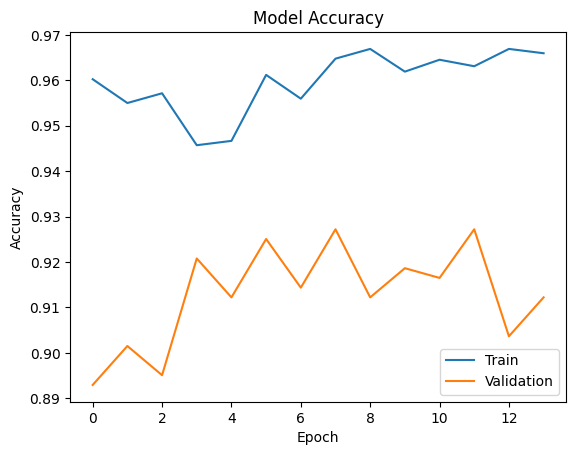

In [ ]:
# Summarize History for Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower right')
plt.show()

Initially, training accuracy surges, then stabilizes near 0.85, suggesting efficient learning. Meanwhile, validation accuracy shows a more gradual increase, reaching around 0.9. This indicates the model generalizes well to unseen data, though further training may yield marginal gains.

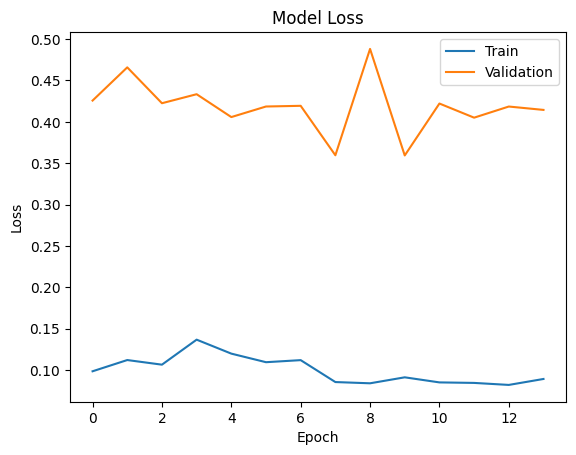

In [ ]:
# Summarize History for Loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper right')
plt.show()

The graph illustrates the training and validation loss trends over epochs. Initially, training loss decreases rapidly, signifying effective learning. It then levels off at a low value, indicating the model's proficiency in fitting the training data. Additionally, validation loss mirrors the behavior of training loss, suggesting that the model generalizes well to unseen data.

In [ ]:
conv_model.save('/content/drive/MyDrive/FYP/COVID-19_Radiography_Dataset/conv_model_tuned.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

